In [18]:
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import scipy.stats as st
import emcee
import dill
import incredible as cr
from pygtc import plotGTC
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
y = np.array([39.30917,35.13419,5.417072,59.75137,30.69077,14.45971,27.07368,27.48429,80.60219,483.1432,24.65057,
              22.36524,43.39081,39.89816,30.67409,6.905061,53.69709,9.504133,41.07874,10.9369,48.29861,61.34125,
              68.37279,30.51124,26.74462,13.7165,6.043301,976.1495,27.20097,7.818419,5.589193,3.310114,271.8901,
              126.0384,99.51247,249.1279,403.0484,3.071718,0.9434036,54.94336,1.529382,8.441071,19.59434,59.43049,
              77.21293,29.6533,286.7116,11.2386,9.511912,29.04711,33.77766,151.4803,223.3557,12.33816,25.22682,
              26.86597,339.7084,405.6737,3.809868,221.6523,307.2994,73.36697,42.15523,36.74785,5.415392,69.4721,
              136.8073,17.3534,4.135966,20.19435,79.06968,8.095599,4.474533,44.90669,85.891,1.636425,75.39335,
              15.94149,2.828709,20.5636,41.52905,42.51133,104.3908,67.41335,13.80204,394.9841,33.90415,84.78714,
              36.77924,14.48424,66.01276,2.910331,92.79938,29.74337,42.40971,1.692674,1.039994,120.5902,154.7106,
              14.38967,147.8399,166.5054,87.53685,22.63141,638.1976,273.6167,593.4997,45.57279,87.30421,75.03385,
              18.33932,36.05779,3.659462,263.9074,0.2432062,8.499095,1.160031,38.16615,41.65371,361.5,148.9294,
              10.25777,71.29159,10.02279,16.36062,601.1667,4.960311,12.22526,87.54137,48.48371,78.56777,212.8153,
              77.0353,62.7624,81.26739,34.36881,42.63432,264.4551,15.24863,25.94133,35.88882,34.94669,222.5425,
              304.9676,19.68377,7.216153,17.61534,32.25887,14.08842,773.5914])

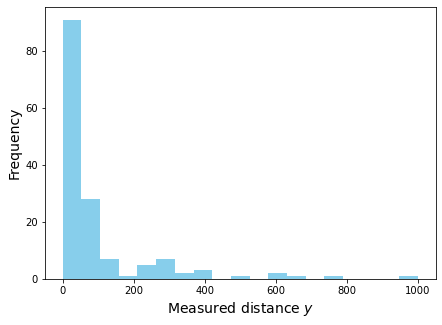

In [151]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
bins = np.linspace(0,1000,20)
plt.hist(y, bins=bins, color="skyblue");
plt.xlabel("Measured distance $y$", fontsize=14);
plt.ylabel("Frequency", fontsize=14);

In [159]:
def T(yy):
    """
    Argument: a data vector (either the real data or a simulated data set)
    Returns: a scalar test statistic computed from the argument
    """
    return np.array(yy<100).sum()

In [160]:
T_true = T(y)
print("The test statistic of the real data is T =", T_true)

The test statistic of the real data is T = 118


In [32]:
# This is something we can throw to discourage direct instantiation of the base class
class VirtualClassError(Exception):
    def __init__(self):
        Exception.__init__(self,"Do not directly instantiate the base Model class!")

class Model:
    """
    Base class for inference and model evaluation in a simple cluster mis-centering analysis.
    In all these functions, `params' is a dictionary of model parameters.
    """
    def __init__(self):
        """
        Note: derived classes should have their own __init__ function which ends by calling this one
        """
        # Storage for MCMC samples from fitting the model
        self.samples = None
        self.Nsamples = 0
        # Lines below are meant as a template for derived classes, do not uncomment for the base class
        #
        # A name for the model!
        #self.name = '...'
        #
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # Named arguments of other functions that correspond to parameters should appear in this order
        #self.param_names = [...]
        #
        # parameter names as display text (for plot labels),
        #self.param_labels = [...]
        #
        # and a dictionary of priors (keys must match param_names)
        #self.priors = {...}
  
    def log_prior(self, **params):
        """
        Return the log prior PDF p(params|H)
        """
        raise VirtualClassError # to be overriden by child classes

    def draw_samples_from_prior(self, N):
        """
        Return N samples from the prior PDF p(params|H) as a list of dictionaries
        """
        raise VirtualClassError # to be overriden by child classes

    def log_likelihood(self, **params):
        """
        Return the log of the likelihood function L(params) = p(y|params,H)
        """
        raise VirtualClassError # to be overriden by child classes
    
    def sampling_distribution(self, yy, **params):
        """
        Return the sampling distribution p(yy|params,H) at a point in data space yy given parameter(s) args
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        raise VirtualClassError # to be overriden by child classes 
        
    def generate_replica_dataset(self, N, **params):
        """
        Return a replica dataset y_rep from the sampling distribution p(y_rep|args,H).
        (Length N should match the real data)
        """
        raise VirtualClassError # to be overriden by child classes
        
    def log_posterior(self, parameterlist=None, **params):
        """
        Return the log of the (unnormalized) posterior PDF p(params|y,H)
        
        The parameterlist argument is there for compatibility with emcee.
        This will be an infinite loop if you named one of your parameters "parameterlist", but in that case
        you deserve it.
        This also means that for even a simple call, we would need to specify the parameter name(s),
         i.e. not log_posterior(pval), but log_posterior(param=pval). This doesn't seem unreasonable.
        """
        if parameterlist is not None:
            pdict = {k:parameterlist[i] for i,k in enumerate(self.param_names)}
            return self.log_posterior(**pdict)
        lnp = self.log_prior(**params)
        if lnp != -np.inf:
            lnp += self.log_likelihood(**params)
        return lnp

    def draw_samples_from_posterior(self, starting_params, nsteps, nwalkers=8, threads=1):
        """
        Use emcee to draw samples from P(params|y,H). Hopefully it Just Works.
        You could try using e.g. threads=4 to speed things up with multiprocessing.
        """
      
        # The density to sample is this model's own posterior PDF
        npars = len(starting_params)        
        self.sampler = emcee.EnsembleSampler(nwalkers, npars, self.log_posterior, threads=threads) 
        
        # Generate an ensemble of walkers within +/-1% of the guess:
        theta_0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
        # Note that the initial parameter array theta_0 should have dimensions nwalkers × npars
        
        # Evolve the ensemble:
        self.sampler.run_mcmc(theta_0, nsteps)
        
        # Plot the raw samples:
        plt.rcParams['figure.figsize'] = (12.0, 4.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.sampler.chain[:min(8,nwalkers),:,:], ax, labels=self.param_labels);

    def check_chains(self, burn, maxlag):
        '''
        Ignoring `burn` samples from the front of each chain, compute convergence criteria and
        effective number of samples.
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        tmp_samples = [self.sampler.chain[i,burn:,:] for i in range(nwalk)]
        print('R =', cr.GelmanRubinR(tmp_samples))
        print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
        print('NB: Since walkers are not independent, these will be optimistic!')

    def remove_burnin(self, burn):
        '''
        Remove `burn` samples from the front of each chain, and concatenate
        Plot, and store the result in self.samples
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        self.samples = self.sampler.chain[:,burn:,:].reshape(nwalk*(nsteps-burn), npars)
        self.Nsamples = self.samples.shape[0]
        plt.rcParams['figure.figsize'] = (12.0, 4.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.samples, ax, labels=self.param_labels);
        
    def posterior_mean(self):
        '''
        Helper function for computing the posterior mean of each parameter (from MCMC samples)
        '''
        m = np.mean(self.samples, axis=0)
        return {k:m[i] for i,k in enumerate(self.param_names)}

In [80]:
class ExponentialModel(Model):
    """
    Simple exponential model for mis-centering.
    """
    def __init__(self):
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # A name for the model!
        self.name = 'Exponential Model'
        # Named arguments of other functions that correspond to parameters should appear in this order
        self.param_names = ['a']
        # parameter names as display text (for plot labels),
        self.param_labels = [r'$a$']
        # and a dictionary of priors (keys must match param_names)
        self.priors =  {'a':np.linspace(0.001,1,100)}
        # The next line finishes initialization by calling the parent class' __init__
        Model.__init__(self)
  
    def log_prior(self, a):
            """
            Return the log prior PDF P(a1|H)
            """
            return 0

    def draw_samples_from_prior(self, N):
        """
        Return N samples of a from the prior PDF p(a|H) as a 2D array
        (one column per parameter)
        """
        priors_list = [self.priors[k][:N] for i,k in enumerate(self.priors)]
        priors_list = np.array(priors_list)
        
        return priors_list

    def log_likelihood(self, a):
        """
        Evaluate the log of the likelihood function L(a) = p(y|a,H)
        """
        return np.sum(st.expon.logpdf(y, scale=a))
    
    def sampling_distribution(self, yy, a):
        """
        Evaluate the sampling distribution PDF p(yy|a,H) at a point in data space yy given parameter value a
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        return st.expon.pdf(yy, scale=a)
        
    def generate_replica_dataset(self, N, a):
        """
        Return a replica data set y_rep from the sampling distribution p(y_rep|a,H).
        (Length N should match the real data)
        """
        xs = np.linspace(0, a*100, 1000001)
        my_pdfs = st.expon.pdf(xs, scale=a)
        my_cdf = np.cumsum(my_pdfs)
        my_cdf = my_cdf / my_cdf[-1]

        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')

        sample = func_ppf(np.random.uniform(size=N))
        
        return sample

In [81]:
Model1 = ExponentialModel()
print("12 sample values drawn from the prior of Model1: ", Model1.draw_samples_from_prior(12))

12 sample values drawn from the prior of Model1:  [[0.001      0.01109091 0.02118182 0.03127273 0.04136364 0.05145455
  0.06154545 0.07163636 0.08172727 0.09181818 0.10190909 0.112     ]]


In [77]:
for a in [1.0, 10.0, 100.0, -3.14]:
    print('Log-posterior for a=', a, ' = ', Model1.log_posterior(a=a))

Log-posterior for a= 1.0  =  -14238.7914788
Log-posterior for a= 10.0  =  -1769.2669118291071
Log-posterior for a= 100.0  =  -833.1634426862138
Log-posterior for a= -3.14  =  nan


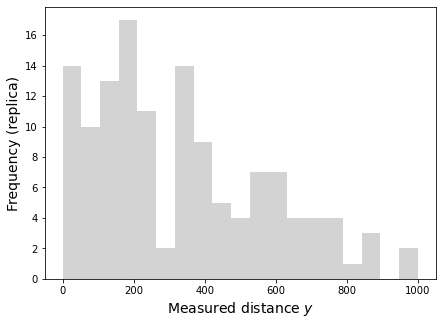

In [86]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.hist(Model1.generate_replica_dataset(len(y), 500.), bins=bins, color="lightgray");
plt.xlabel("Measured distance $y$", fontsize=14);
plt.ylabel("Frequency (replica)", fontsize=14);

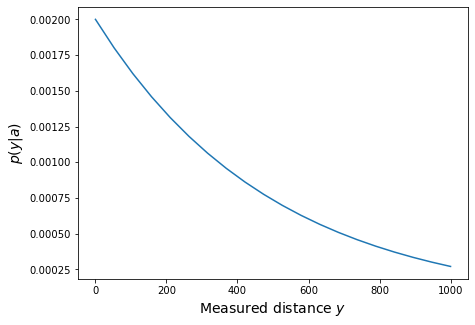

In [87]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.plot(bins, Model1.sampling_distribution(bins, 500.));
plt.xlabel("Measured distance $y$", fontsize=14);
plt.ylabel("$p(y|a)$", fontsize=14);

## 2b Fitting the model to the data

CPU times: user 21 s, sys: 337 µs, total: 21 s
Wall time: 21 s


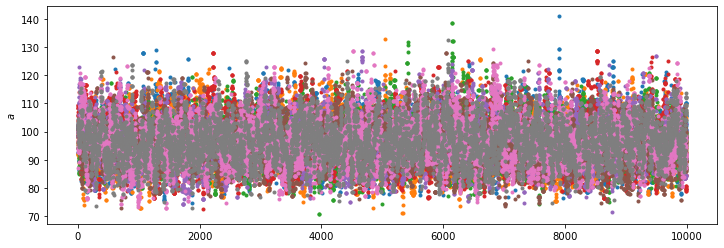

In [90]:
%%time
Model1.draw_samples_from_posterior(starting_params=[100], nsteps=int(1e4), nwalkers=8)

In [91]:
Model1.check_chains(500,500)

R = [1.00144173]
neff = [2664.33222263]
NB: Since walkers are not independent, these will be optimistic!


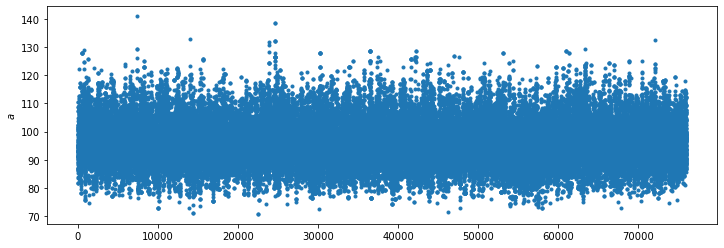

In [92]:
Model1.remove_burnin(500)

In [93]:
print("Posterior mean value of a = ", Model1.posterior_mean())

Posterior mean value of a =  {'a': 96.45081296095073}


## 2c. Visually compare the posterior predictions with the data.

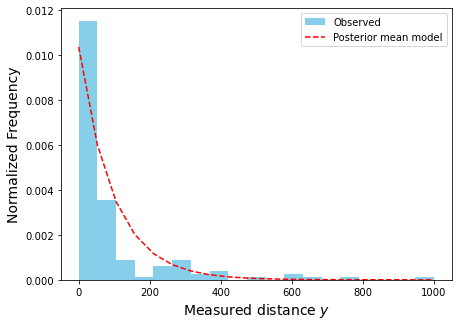

In [94]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)

# First the histogram of observed data, as backdrop:
plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed")

# Now overlay a curve following the sampling distribution conditioned on the posterior mean value of a1: 
pp = Model1.sampling_distribution(bins, **Model1.posterior_mean())
plt.plot(bins, pp, linestyle="dashed", color="red", label="Posterior mean model")

plt.xlabel("Measured distance $y$", fontsize=14)
plt.ylabel("Normalized Frequency", fontsize=14)
plt.legend();

In [99]:
np.shape(Model1.samples)
print(Model1.Nsamples)

76000


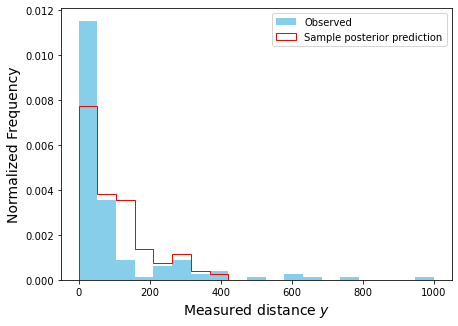

In [95]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)

# First the histogram of observed data, as backdrop:
plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed");

# Choose a posterior sample at random and generate a replica dataset, and show its histogram
j = np.random.randint(0, Model1.Nsamples)
mock = Model1.generate_replica_dataset(len(y), *Model1.samples[j,:])
plt.hist(mock, bins=bins, alpha=1.0, histtype="step", color="red", density=True, label="Sample posterior prediction")

plt.xlabel("Measured distance $y$", fontsize=14)
plt.ylabel("Normalized Frequency", fontsize=14)
plt.legend();

In [100]:
def visual_check(axes, Model, Nreps=None):
    # First the histogram of observed data, as backdrop:
    axes.hist(y, bins=bins, color="skyblue", density=True, label="Observed");

    # Compute the posterior mean parameters
    pm = Model.posterior_mean()

    # Make a large number of replica datasets, and overlay histograms of them all 
    if Nreps is None: Nreps = len(Model.samples)
    alpha = 5.0 / Nreps
    for jj in np.round(np.linspace(0, len(Model.samples), num=Nreps, endpoint=False)): 
        j = int(jj)
        if j==0:  
            # Plot a dataset drawn from the posterior mean, to give a good legend
            mock = Model.generate_replica_dataset(len(y), **pm)
            axes.hist(mock, bins=bins, histtype="step", alpha=1.0, color="red", density=True,
                     label="Sample posterior predictions");
        else:     
            # Take the next posterior sample a and generate a replica dataset
            mock = Model.generate_replica_dataset(len(y), *Model.samples[j,:])
            axes.hist(mock, bins=bins, histtype="step", alpha=alpha, color="red", density=True);

    # Include the posterior mean model for comparison
    pp = Model.sampling_distribution(bins, **pm)
    axes.plot(bins, pp, linestyle="dashed", color="red", label="Posterior mean model");

    axes.set_title(Model.name, fontsize=14)
    axes.set_xlabel("Measured distance $y$", fontsize=14)
    axes.set_ylabel("Normalized Frequency", fontsize=14)
    axes.legend();

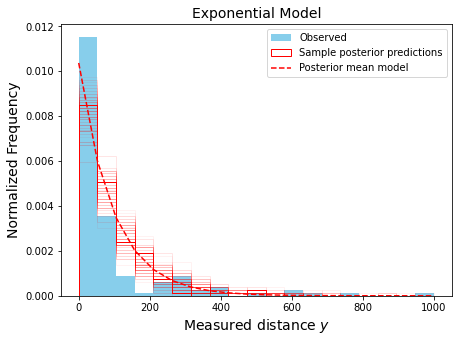

In [101]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
fig, ax = plt.subplots(1)
visual_check(ax, Model1, Nreps=100);

## 2c. Quantitative posterior predictive model check

In [142]:
def distribution_of_T(Model, Nreps=100):
    """
    Compute T(yrep) for each yrep drawn from the posterior predictive distribution,
    using parameter samples stored in Model.
    """
    T_arr = []
    for jj in np.round(np.linspace(0, len(Model.samples), num=Nreps, endpoint=False)): 
        j = int(jj)
        mock = Model.generate_replica_dataset(len(y), *Model.samples[j,:])
        T_cur = T(mock)
        T_arr.append(T_cur)
    
    return np.array(T_arr)

In [143]:
def pvalue(Model):
    TBC()
    return

In [161]:
def posterior_predictive_check(Model, nbins=25, Nreps=100):
    """
    Compute the posterior predictive distribution of the test statistic T(y_rep), and compare with T(y_obs) 
    """
    # Compute distribution of T(yrep):
    TT = distribution_of_T(Model, Nreps=100)
    print(TT)
    
    # Plot:
    plt.rcParams['figure.figsize'] = (7.0, 5.0)
    plt.hist(TT, bins=nbins, histtype="step", color="red", label="$P(T(y_{\\rm rep})|y)$")
    
    # Overlay T(y_obs):
    plt.axvline(x=T(y), color="gray", linestyle="dashed", label="$T(y_{\\rm observed})$")
    plt.xlabel("Test statistic T(y)", fontsize=14)
    plt.ylabel("Posterior predictive probability density", fontsize=14)
    plt.legend();
    
    # Compute p-value:
    #p = pvalue(Model)
    #print("p-value =", p)

    return

[106  91  88  97  98  95  85  96  98 100 103 111  94  94  92  99 101 104
 100 108  87  87 107  98 103 103  93  88  96 104 107 100  99  88  94 106
 103  98 101  98 100  96  90 101  84  92  93  99  86  95  96  92  92  95
  93  87 107 101  90  95 109 111 103  91  88  97  96  96  99  89 100  87
  90  90 105 107  93 110  98  93 102  90  94  87  95  82 104 102 102 100
  92  91 101 104  98  98  99 101  97  94]


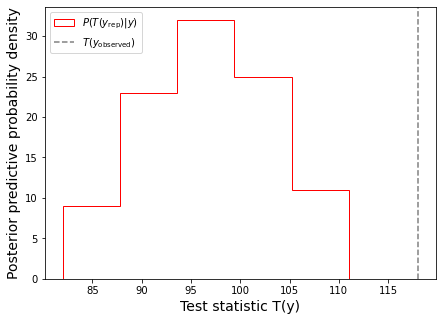

In [162]:
p1 = posterior_predictive_check(Model1, nbins=5, Nreps=100)